### Sufficient Statistics


Let $y_1,y_2,\cdots,y_n\overset{\text{iid}}{\sim} Poisson(\lambda)$ where $\lambda > 0$.
The Sufficient Statistics for y is simply $\sum{y}$

### Our Job

1. Simulate observed Poisson data.
2. Compute the analytic Gamma posterior.
3. Make simulations of $(\theta,\sum{y})$ pairs.
4. Make use of sufficient statistic for the simulated posterior means and variances.
5. Compare simulated summaries against analytic formulas.
6. Fit regression models to the summaries.

First, we setup and simulate observed data. We work with sample sizes up to 𝑛, true 𝜃, and simulate (∑𝑛) Poisson observations.



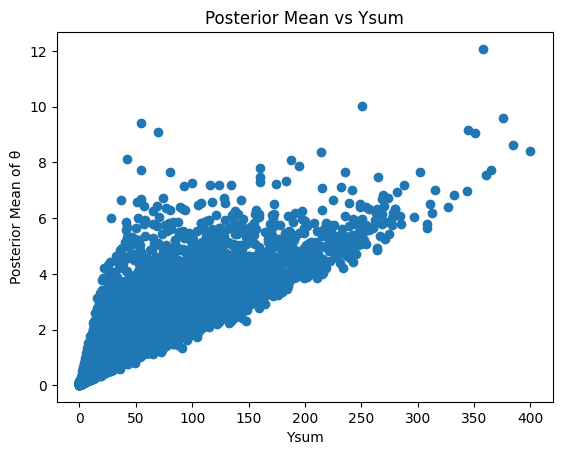

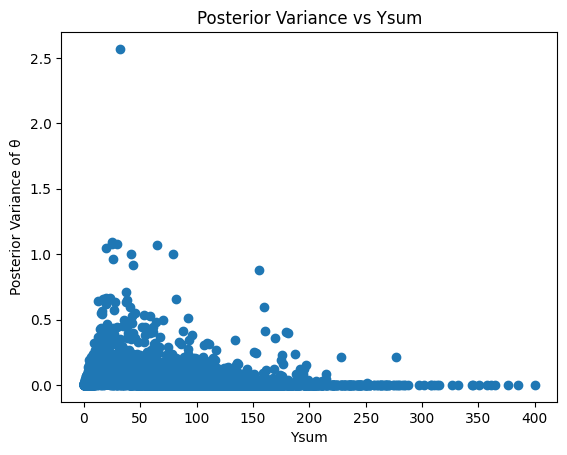

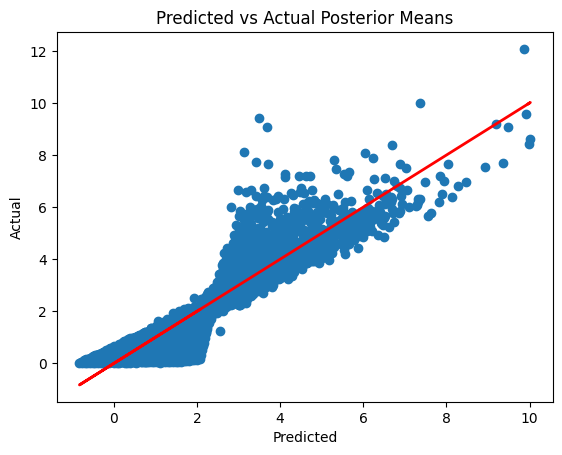

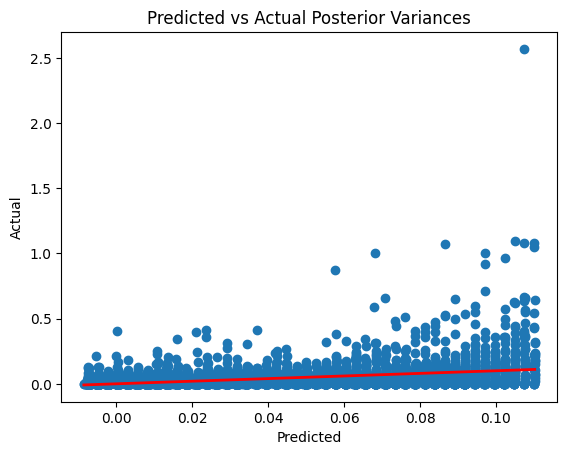

(array([1.]), -1.199040866595169e-14, array([1.]), -3.400058012914542e-16)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gamma, poisson
from sklearn.linear_model import LinearRegression

# Prior parameters
alpha = 1
beta = 1
theta_true = 2
M = 10**3

final_mat = []

for n in range(5, 51):
    theta_vec = np.random.gamma(shape=alpha, scale=1/beta, size=M)
    ysum_vec = [np.sum(np.random.poisson(lam=theta, size=n)) for theta in theta_vec]
    n_vec = [n] * M
    out_mat = np.column_stack((theta_vec, ysum_vec, n_vec))
    final_mat.append(out_mat)

final_mat = np.vstack(final_mat)
final_df = pd.DataFrame(final_mat, columns=['theta', 'ysum', 'n'])

# Get unique (ysum, n) pairs
unique_sum_y = final_df[['ysum', 'n']].drop_duplicates().sort_values(by='ysum').reset_index(drop=True)

# Create list of theta vectors for each (ysum, n)
theta_list = []
for _, row in unique_sum_y.iterrows():
    ysum_i, n_i = row['ysum'], row['n']
    matched_thetas = final_df[(final_df['ysum'] == ysum_i) & (final_df['n'] == n_i)]['theta']
    theta_list.append(matched_thetas.values)

# Compute posterior means, variances, and standard deviations
post_mean_theta = np.array([np.mean(t) if len(t) > 0 else np.nan for t in theta_list])
post_var_theta = np.array([np.var(t) if len(t) > 0 else np.nan for t in theta_list])
post_sd_theta = np.array([np.std(t) if len(t) > 0 else np.nan for t in theta_list])

# Plot posterior mean vs ysum
plt.scatter(unique_sum_y['ysum'], post_mean_theta)
plt.title("Posterior Mean vs Ysum")
plt.xlabel("Ysum")
plt.ylabel("Posterior Mean of θ")
plt.show()

# Plot posterior variance vs ysum
plt.scatter(unique_sum_y['ysum'], post_var_theta)
plt.title("Posterior Variance vs Ysum")
plt.xlabel("Ysum")
plt.ylabel("Posterior Variance of θ")
plt.show()

# Linear regression: post_mean_theta ~ ysum + n
Z_mean = np.column_stack((np.ones(len(unique_sum_y)), unique_sum_y['ysum'], unique_sum_y['n']))
lm_mean = np.linalg.lstsq(Z_mean, post_mean_theta, rcond=None)[0]
y_hat_mean = Z_mean @ lm_mean

# Plot predictions vs actual means
plt.scatter(y_hat_mean, post_mean_theta)
plt.plot(y_hat_mean, y_hat_mean, color='red', linewidth=2)
plt.title("Predicted vs Actual Posterior Means")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Linear regression: post_var_theta ~ ysum + n
mask = ~np.isnan(post_var_theta)
Z_var = Z_mean[mask]
y_var_clean = post_var_theta[mask]
lm_var = np.linalg.lstsq(Z_var, y_var_clean, rcond=None)[0]
y_hat_var = Z_var @ lm_var

# Plot predictions vs actual variances
plt.scatter(y_hat_var, y_var_clean)
plt.plot(y_hat_var, y_hat_var, color='red', linewidth=2)
plt.title("Predicted vs Actual Posterior Variances")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Fit final models to confirm 1:1 relationship
model_mean = LinearRegression().fit(y_hat_mean.reshape(-1, 1), post_mean_theta)
model_var = LinearRegression().fit(y_hat_var.reshape(-1, 1), y_var_clean)

# Display coefficients
model_mean.coef_, model_mean.intercept_, model_var.coef_, model_var.intercept_


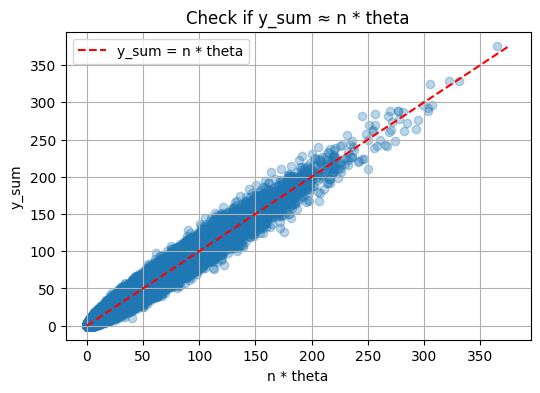

Epoch 0, Loss: 2298.53711
Epoch 100, Loss: -1103.12891
Epoch 200, Loss: -1701.10486
Epoch 300, Loss: -1722.78735
Epoch 400, Loss: -1654.87256
Epoch 500, Loss: -1789.83508
Epoch 600, Loss: -1801.82520
Epoch 700, Loss: -1816.41675
Epoch 800, Loss: -1827.26794
Epoch 900, Loss: -1798.63818


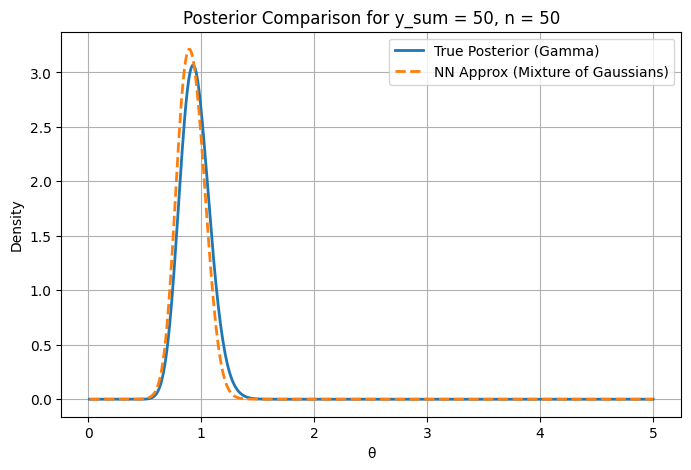

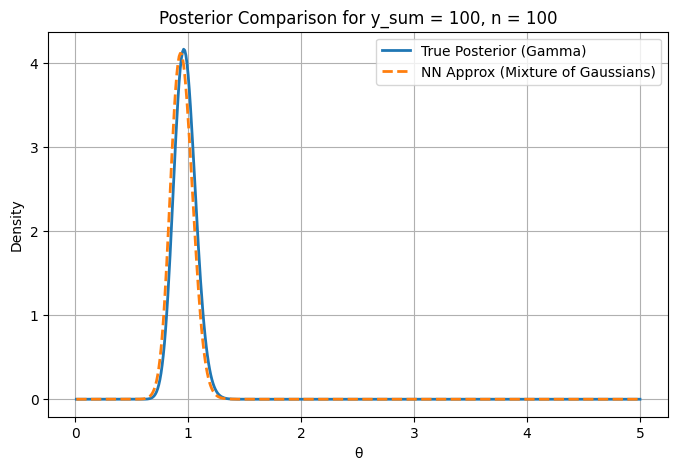

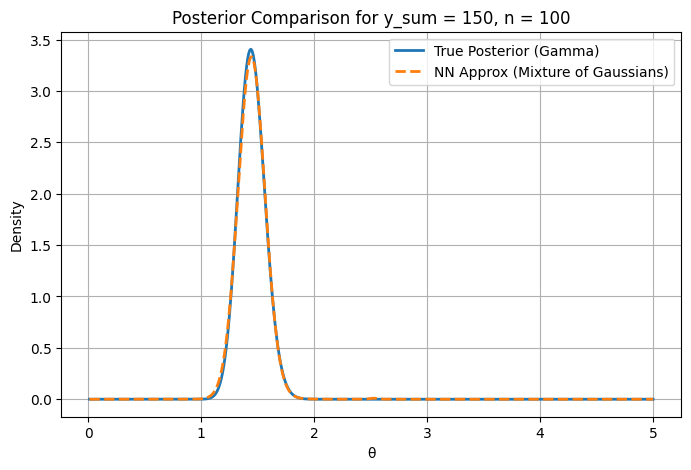

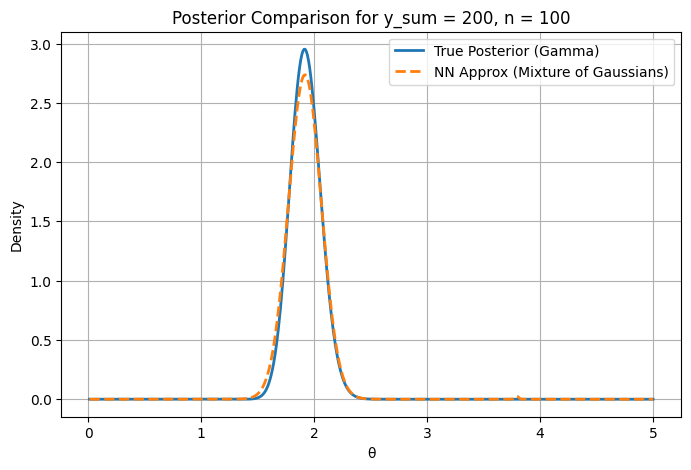

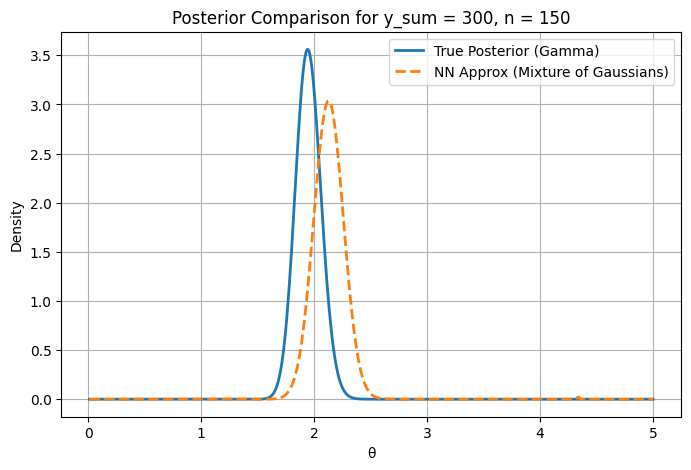

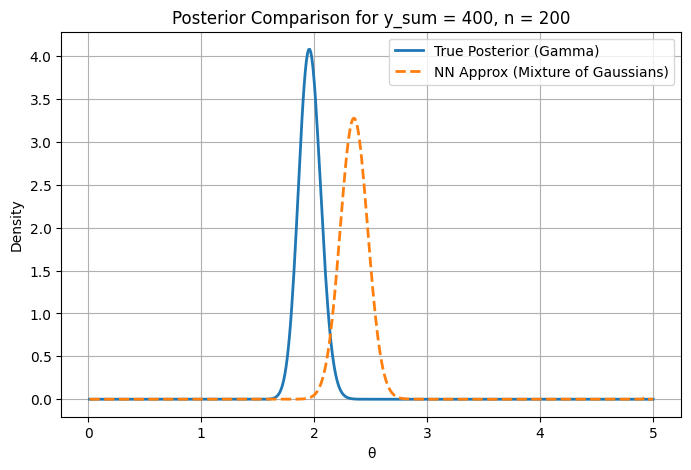

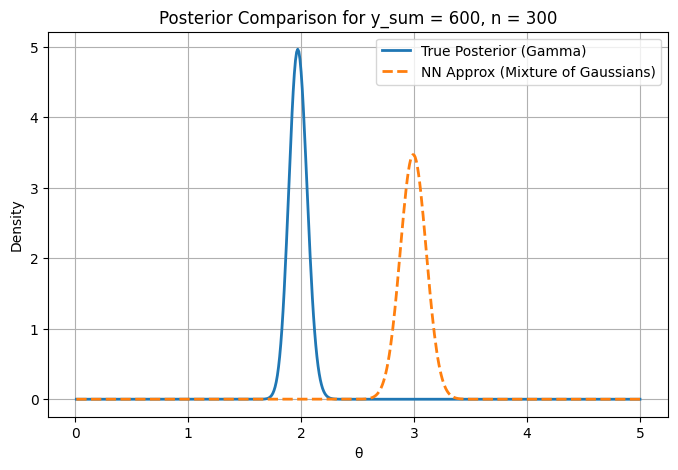

In [2]:
import random
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from scipy.stats import norm, gamma, ks_2samp, wasserstein_distance

# Set seed
SEED = 123
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Set prior parameters
alpha = 2
beta_prior = 5
M = 10000

# Simulate data for multiple n
n_values = list(range(10, 150, 10))
df_final = pd.DataFrame()

for n in n_values:
    theta_vec = np.random.gamma(shape=alpha, scale=1 / beta_prior, size=M)
    y_sum_vec = [np.sum(np.random.poisson(lam=theta, size=n)) for theta in theta_vec]
    n_vec = np.full(M, n)
    df = pd.DataFrame({'theta': theta_vec, 'y_sum': y_sum_vec, 'n': n_vec})
    df_final = pd.concat([df_final, df], ignore_index=True)

# Plot check: y_sum ~= n * theta
plt.figure(figsize=(6, 4))
plt.scatter(df_final['theta'] * df_final['n'], df_final['y_sum'], alpha=0.3)
plt.plot([0, max(df_final['y_sum'])], [0, max(df_final['y_sum'])], 'r--', label='y_sum = n * theta')
plt.xlabel("n * theta")
plt.ylabel("y_sum")
plt.title("Check if y_sum ≈ n * theta")
plt.legend()
plt.grid(True)
plt.show()

# Prepare data for training
unique_pairs = df_final[['y_sum', 'n']].drop_duplicates().reset_index(drop=True)
thetas = [
    df_final[(df_final['y_sum'] == row['y_sum']) & (df_final['n'] == row['n'])]['theta'].values
    for _, row in unique_pairs.iterrows()
]

# Model definition
class MixtureDensityNN(nn.Module):
    def __init__(self, K=8):
        super().__init__()
        self.K = K
        self.backbone = nn.Sequential(
            nn.Linear(2, 64), nn.ReLU(),
            nn.Linear(64, 32), nn.ReLU(),
            nn.Linear(32, 16), nn.ReLU(),
        )
        self.logits_head = nn.Linear(16, K)
        self.mu_head = nn.Linear(16, K)
        self.log_var_head = nn.Linear(16, K)

    def forward(self, x):
        h = self.backbone(x)
        logits = self.logits_head(h)
        weights = torch.softmax(logits, dim=-1)
        mu = self.mu_head(h)
        log_var = self.log_var_head(h)
        return weights, mu, log_var

def mixture_log_likelihood(theta_vals, weights, mu, log_var):
    var = torch.exp(log_var)
    theta = theta_vals.expand(-1, mu.shape[1])
    log_probs = -0.5 * (log_var + np.log(2 * np.pi) + (theta - mu) ** 2 / var)
    log_weighted = torch.log(weights + 1e-8) + log_probs
    log_sum_exp = torch.logsumexp(log_weighted, dim=1)
    return -log_sum_exp.mean()

# Training
model = MixtureDensityNN(K=8)
optimizer = optim.Adam(model.parameters(), lr=0.01)
y_max = df_final['y_sum'].max()
n_max = df_final['n'].max()

for epoch in range(1000):
    model.train()
    total_loss = 0.0
    for (y_val, n_val), theta_arr in zip(unique_pairs.values, thetas):
        if len(theta_arr) < 2 or np.var(theta_arr) == 0:
            continue
        x_input = torch.tensor([[y_val / y_max, n_val / n_max]], dtype=torch.float32)
        weights, mu, log_var = model(x_input)
        theta_vals = torch.tensor(theta_arr, dtype=torch.float32).view(-1, 1)
        loss_i = mixture_log_likelihood(theta_vals, weights, mu, log_var)
        total_loss += loss_i

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {total_loss.item():.5f}")
# Define test cases: list of (y_sum, n) combinations
test_cases = [
    (50, 50),      # θ ≈ 1
    (100, 100),    # θ ≈ 1
    (150, 100),    # θ ≈ 1.5
    (200, 100),    # θ ≈ 2.0
    (300, 150),    # θ ≈ 2.0
    (400, 200),    # θ ≈ 2.0
    (600, 300),    # θ ≈ 2.0
]
theta_range = np.linspace(0.01, 5.0, 500)

for y_obs, n_obs in test_cases:
    x_test = torch.tensor([[y_obs / y_max, n_obs / n_max]], dtype=torch.float32)
    
    with torch.no_grad():
        weights, mu, log_var = model(x_test)

    # Approximate posterior (Mixture of Gaussians)
    approx_pdf = np.zeros_like(theta_range)
    for k in range(weights.shape[1]):
        pi_k = weights[0, k].item()
        mu_k = mu[0, k].item()
        std_k = np.sqrt(np.exp(log_var[0, k].item()))
        approx_pdf += pi_k * norm.pdf(theta_range, loc=mu_k, scale=std_k)

    # True posterior (Gamma)
    alpha_post = alpha + y_obs
    beta_post = beta_prior + n_obs
    true_pdf = gamma.pdf(theta_range, a=alpha_post, scale=1 / beta_post)

    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(theta_range, true_pdf, label="True Posterior (Gamma)", lw=2)
    plt.plot(theta_range, approx_pdf, label="NN Approx (Mixture of Gaussians)", lw=2, linestyle="--")
    plt.title(f"Posterior Comparison for y_sum = {y_obs}, n = {n_obs}")
    plt.xlabel("θ")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.show()


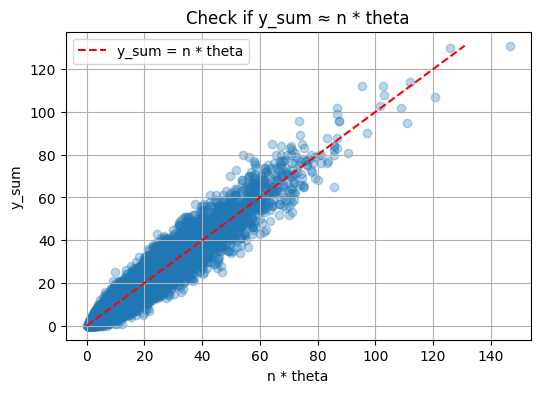

Epoch 0, Loss: 113.94271
Epoch 100, Loss: -63.19751
Epoch 200, Loss: -73.17896
Epoch 300, Loss: -73.13232
Epoch 400, Loss: -72.72912
Epoch 500, Loss: -73.49786
Epoch 600, Loss: -73.00909
Epoch 700, Loss: -72.94398
Epoch 800, Loss: -73.41946
Epoch 900, Loss: -73.64166


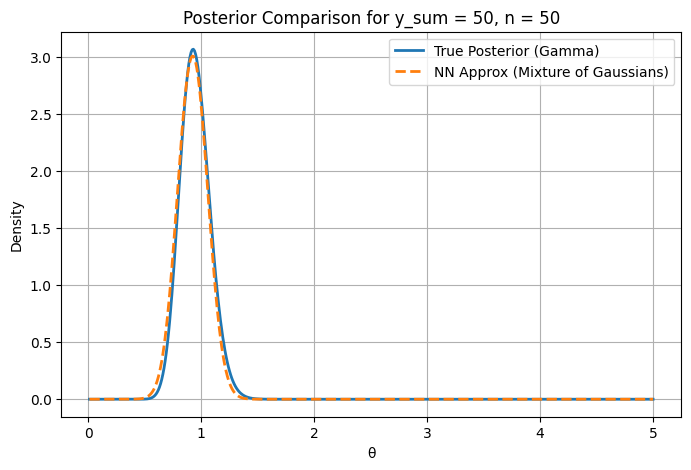

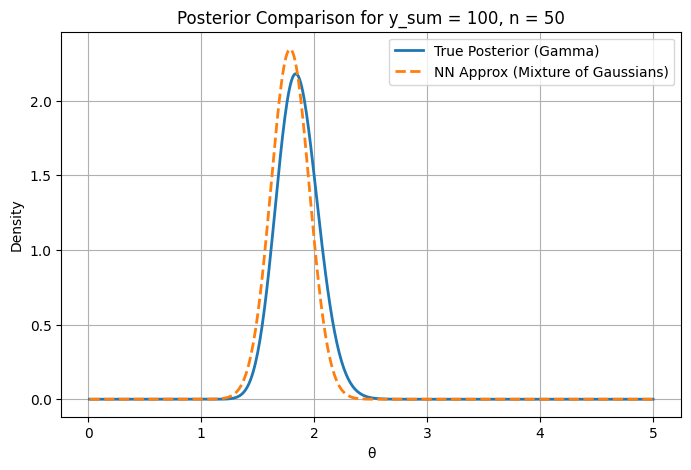

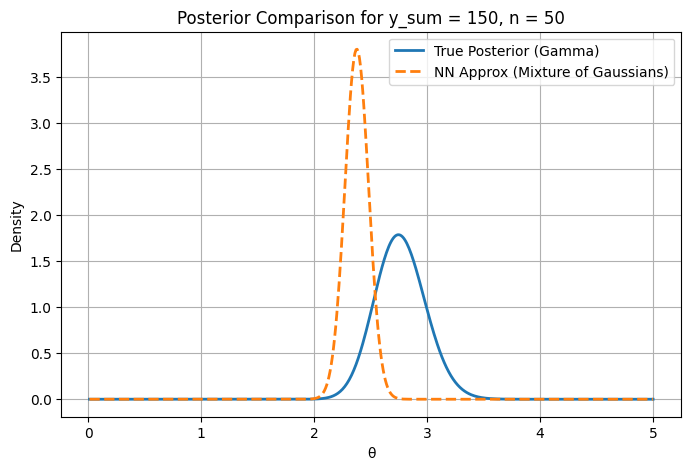

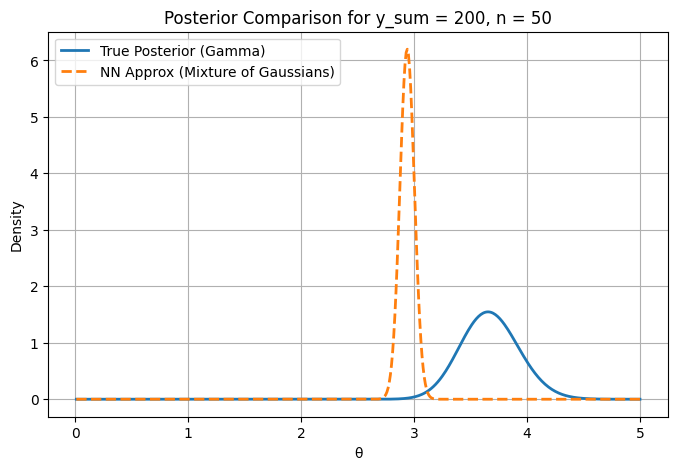

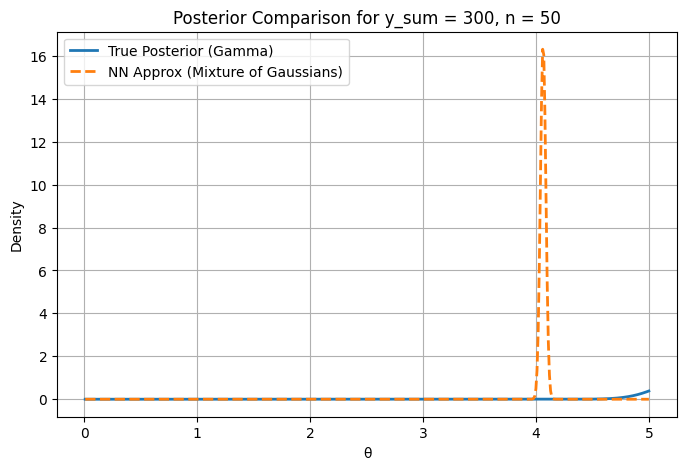

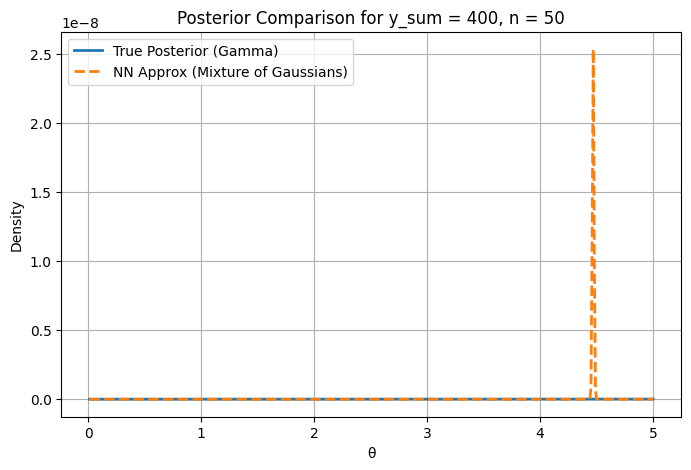

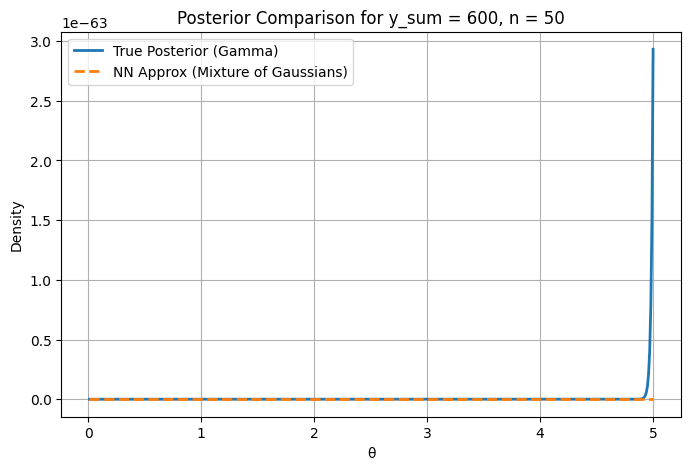

In [6]:
import random
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from scipy.stats import norm, gamma, ks_2samp, wasserstein_distance

# Set seed
SEED = 123
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Set prior parameters
alpha = 2
beta_prior = 5
M = 10000

# Simulate data for multiple n
n_values = list(range(51,52))
df_final = pd.DataFrame()

for n in n_values:
    theta_vec = np.random.gamma(shape=alpha, scale=1 / beta_prior, size=M)
    y_sum_vec = [np.sum(np.random.poisson(lam=theta, size=n)) for theta in theta_vec]
    n_vec = np.full(M, n)
    df = pd.DataFrame({'theta': theta_vec, 'y_sum': y_sum_vec, 'n': n_vec})
    df_final = pd.concat([df_final, df], ignore_index=True)

# Plot check: y_sum ~= n * theta
plt.figure(figsize=(6, 4))
plt.scatter(df_final['theta'] * df_final['n'], df_final['y_sum'], alpha=0.3)
plt.plot([0, max(df_final['y_sum'])], [0, max(df_final['y_sum'])], 'r--', label='y_sum = n * theta')
plt.xlabel("n * theta")
plt.ylabel("y_sum")
plt.title("Check if y_sum ≈ n * theta")
plt.legend()
plt.grid(True)
plt.show()

# Prepare data for training
unique_pairs = df_final[['y_sum', 'n']].drop_duplicates().reset_index(drop=True)
thetas = [
    df_final[(df_final['y_sum'] == row['y_sum']) & (df_final['n'] == row['n'])]['theta'].values
    for _, row in unique_pairs.iterrows()
]

# Model definition
class MixtureDensityNN(nn.Module):
    def __init__(self, K=8):
        super().__init__()
        self.K = K
        self.backbone = nn.Sequential(
            nn.Linear(2, 64), nn.ReLU(),
            nn.Linear(64, 32), nn.ReLU(),
            nn.Linear(32, 16), nn.ReLU(),
        )
        self.logits_head = nn.Linear(16, K)
        self.mu_head = nn.Linear(16, K)
        self.log_var_head = nn.Linear(16, K)

    def forward(self, x):
        h = self.backbone(x)
        logits = self.logits_head(h)
        weights = torch.softmax(logits, dim=-1)
        mu = self.mu_head(h)
        log_var = self.log_var_head(h)
        return weights, mu, log_var

def mixture_log_likelihood(theta_vals, weights, mu, log_var):
    var = torch.exp(log_var)
    theta = theta_vals.expand(-1, mu.shape[1])
    log_probs = -0.5 * (log_var + np.log(2 * np.pi) + (theta - mu) ** 2 / var)
    log_weighted = torch.log(weights + 1e-8) + log_probs
    log_sum_exp = torch.logsumexp(log_weighted, dim=1)
    return -log_sum_exp.mean()

# Training
model = MixtureDensityNN(K=2)
optimizer = optim.Adam(model.parameters(), lr=0.01)
y_max = df_final['y_sum'].max()
n_max = df_final['n'].max()

for epoch in range(1000):
    model.train()
    total_loss = 0.0
    for (y_val, n_val), theta_arr in zip(unique_pairs.values, thetas):
        if len(theta_arr) < 2 or np.var(theta_arr) == 0:
            continue
        x_input = torch.tensor([[y_val / y_max, n_val / n_max]], dtype=torch.float32)
        weights, mu, log_var = model(x_input)
        theta_vals = torch.tensor(theta_arr, dtype=torch.float32).view(-1, 1)
        loss_i = mixture_log_likelihood(theta_vals, weights, mu, log_var)
        total_loss += loss_i

    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {total_loss.item():.5f}")
# Define test cases: list of (y_sum, n) combinations
test_cases = [
    (50, 50),      # θ ≈ 1
    (100, 50),    # θ ≈ 1
    (150, 50),    # θ ≈ 1.5
    (200, 50),    # θ ≈ 2.0
    (300, 50),    # θ ≈ 2.0
    (400, 50),    # θ ≈ 2.0
    (600, 50),    # θ ≈ 2.0
]
theta_range = np.linspace(0.01, 5.0, 500)

for y_obs, n_obs in test_cases:
    x_test = torch.tensor([[y_obs / y_max, n_obs / n_max]], dtype=torch.float32)
    
    with torch.no_grad():
        weights, mu, log_var = model(x_test)

    # Approximate posterior (Mixture of Gaussians)
    approx_pdf = np.zeros_like(theta_range)
    for k in range(weights.shape[1]):
        pi_k = weights[0, k].item()
        mu_k = mu[0, k].item()
        std_k = np.sqrt(np.exp(log_var[0, k].item()))
        approx_pdf += pi_k * norm.pdf(theta_range, loc=mu_k, scale=std_k)

    # True posterior (Gamma)
    alpha_post = alpha + y_obs
    beta_post = beta_prior + n_obs
    true_pdf = gamma.pdf(theta_range, a=alpha_post, scale=1 / beta_post)

    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(theta_range, true_pdf, label="True Posterior (Gamma)", lw=2)
    plt.plot(theta_range, approx_pdf, label="NN Approx (Mixture of Gaussians)", lw=2, linestyle="--")
    plt.title(f"Posterior Comparison for y_sum = {y_obs}, n = {n_obs}")
    plt.xlabel("θ")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.show()
